In [247]:
import numpy as np
import pandas as pd
import scipy, scipy.signal

from datetime import date
import time

from random import seed
from random import random

import os, os.path
import shutil

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import matplotlib
import matplotlib.pyplot as plt
from pylab import imshow

import h5py
import sys
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/NASA/Python_codes/')
import NASA_core as nc

import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter
# import NASA_plot_core.py as rcp

# Read Training Set Labels

In [2]:
training_set_dir = "/Users/hn/Documents/01_research_data/NASA/ML_data/"
ground_truth_labels = pd.read_csv(training_set_dir+"train_labels.csv")
print ("Unique Votes: ", ground_truth_labels.Vote.unique())
print (len(ground_truth_labels.ID.unique()))
ground_truth_labels.head(2)

Unique Votes:  [2 1]
1849


,ID,Vote
0,99837_WSDA_SF_2017,2
1,114615_WSDA_SF_2017,1


# Start VI images

In [3]:
# interval_size=10
# no_data = 365//10

In [4]:
VI_idx = "EVI"
data_dir = "/Users/hn/Documents/01_research_data/NASA/VI_TS/04_regularized_TS/"

In [5]:
file_names = ["regular_Walla2015_EVI_JFD.csv", "regular_AdamBenton2016_EVI_JFD.csv", 
              "regular_Grant2017_EVI_JFD.csv", "regular_FranklinYakima2018_EVI_JFD.csv"]

data=pd.DataFrame()

for file in file_names:
    curr_file=pd.read_csv(data_dir + file)
    curr_file['human_system_start_time'] = pd.to_datetime(curr_file['human_system_start_time'])
    
    # These data are for 3 years. The middle one is the correct one
    all_years = sorted(curr_file.human_system_start_time.dt.year.unique())
    if len(all_years)==3 or len(all_years)==2:
        proper_year = all_years[1]
    elif len(all_years)==1:
        proper_year = all_years[0]

    curr_file = curr_file[curr_file.human_system_start_time.dt.year==proper_year]
    data=pd.concat([data, curr_file])

data.reset_index(drop=True, inplace=True)
data.head(2)

,ID,human_system_start_time,EVI
0,135073_WSDA_SF_2015,2015-01-10,0.049624
1,135073_WSDA_SF_2015,2015-01-20,0.026503


# More-Bands files

In [8]:
more_band_dir = "/Users/hn/Documents/01_research_data/NASA/VI_TS/04_regularized_TS/wide_DFs/"
allBands_AllCounties=pd.read_csv(more_band_dir + "wide_allCounties_moreBands.csv")


In [38]:
# more_band_dir = "/Users/hn/Documents/01_research_data/NASA/VI_TS/04_regularized_TS/"
# moreBand_fNames=[x for x in os.listdir(more_band_dir) if x.endswith(".csv")]
# moreBand_fNames=[x for x in moreBand_fNames if "moreBands" in x]

### Pick up the fields whose "true" label we know

In [75]:
ID_list = list(ground_truth_labels.ID.unique())
ground_truth = data[data.ID.isin(ID_list)].copy()
allBands_AllCounties = allBands_AllCounties[allBands_AllCounties.ID.isin(ID_list)]

ground_truth.reset_index(drop=True, inplace=True)
allBands_AllCounties.reset_index(drop=True, inplace=True)

In [258]:
ground_truth.shape # 67255

(67255, 3)

# Sort the order of time-series and experts' labels identically

In [48]:
ground_truth.sort_values(by=["ID", 'human_system_start_time'], inplace=True)
ground_truth_labels.sort_values(by=["ID"], inplace=True)

ground_truth.reset_index(drop=True, inplace=True)
ground_truth_labels.reset_index(drop=True, inplace=True)

In [49]:
assert (len(ground_truth.ID.unique()) == len(ground_truth_labels.ID.unique()))

In [50]:
print (list(ground_truth.ID)[0])
print (list(ground_truth_labels.ID)[0])
print ("____________________________________")
print (list(ground_truth.ID)[-1])
print (list(ground_truth_labels.ID)[-1])
print ("____________________________________")
print (list(ground_truth.ID.unique())==list(ground_truth_labels.ID.unique()))

100048_WSDA_SF_2017
100048_WSDA_SF_2017
____________________________________
99909_WSDA_SF_2017
99909_WSDA_SF_2017
____________________________________
True


# Logistic Regression with Pandas

I want to split pandas dataframes so that we have access to IDs easily.

### Convert VI table to wide format

In [51]:
EVI_colnames = [VI_idx + "_" + str(ii) for ii in range(1, 37) ]
columnNames = ["ID"] + EVI_colnames
ground_truth_wide = pd.DataFrame(columns=columnNames, 
                             index=range(len(ground_truth.ID.unique())))
ground_truth_wide["ID"] = ground_truth.ID.unique()

In [52]:
for an_ID in ground_truth.ID.unique():
    curr_df = ground_truth[ground_truth.ID==an_ID]
    
    ground_truth_wide_indx = ground_truth_wide[ground_truth_wide.ID==an_ID].index
    ground_truth_wide.loc[ground_truth_wide_indx, "EVI_1":"EVI_36"] = curr_df.EVI.values[:36]
ground_truth_wide.head(2)

,ID,EVI_1,EVI_2,EVI_3,EVI_4,EVI_5,EVI_6,EVI_7,EVI_8,EVI_9,...,EVI_27,EVI_28,EVI_29,EVI_30,EVI_31,EVI_32,EVI_33,EVI_34,EVI_35,EVI_36
0,100048_WSDA_SF_2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072227,0.088491,...,0.111507,0.119534,0.13248,0.061173,0.055843,0.050513,0.045183,0.039854,0.045165,0.050476
1,100081_WSDA_SF_2017,0.014832,0.167038,0.319244,0.47145,0.378153,0.284855,0.198468,0.290683,0.398445,...,0.096717,0.117915,0.159058,0.121182,0.060591,0.0,0.050004,0.100009,0.102269,0.104529


In [2]:
ground_truth.head(2)

NameError: name 'ground_truth' is not defined

In [54]:
ground_truth_labels.head(2)

,ID,Vote
0,100048_WSDA_SF_2017,1
1,100081_WSDA_SF_2017,1


# Check if we did the right things:

In [56]:
(ground_truth_wide.ID==ground_truth_labels.ID).sum()

1849

### Sort the order of time-series and experts' labels identically

In [269]:
ground_truth.sort_values(by=["ID", 'human_system_start_time'], inplace=True)
ground_truth_labels.sort_values(by=["ID"], inplace=True)

ground_truth.reset_index(drop=True, inplace=True)
ground_truth_labels.reset_index(drop=True, inplace=True)

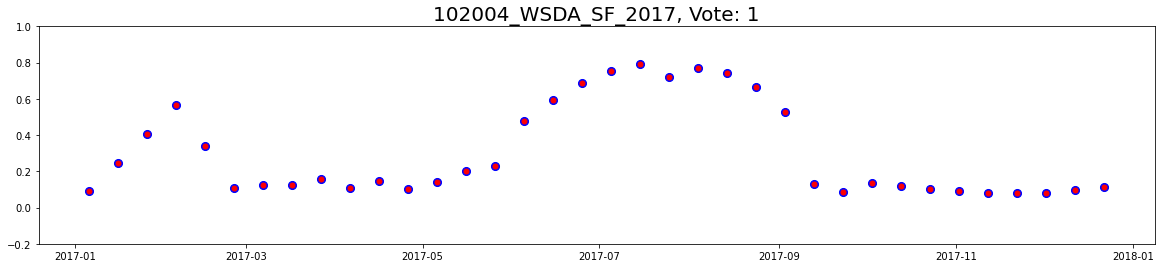

In [57]:
plt.figure(figsize=(20,4))
plt.subplot(1, 1, 1)

field_number = 120
ID = ground_truth.ID.unique()[field_number]
plt.scatter(ground_truth[ground_truth.ID==ID]["human_system_start_time"].values[:36],
            ground_truth[ground_truth.ID==ID][VI_idx].values[:36],
            marker='o', s=65, c='b', label=VI_idx);

plt.scatter(ground_truth[ground_truth.ID==ID]["human_system_start_time"].values[:36],
            ground_truth_wide[ground_truth_wide.ID==ID].values[0][1:],
            marker='o', s=25, c='r', label=VI_idx);
plt.ylim([-0.2, 1])

vote = str(ground_truth_labels[ground_truth_labels.ID==ground_truth.ID.unique()[field_number]]['Vote'].values[0])
title = ground_truth.ID.unique()[field_number] + ", " + "Vote: " + vote
plt.title(title , fontsize = 20);

In [58]:
len(ground_truth_wide.ID.unique())==len(ground_truth_labels.ID.unique())

True

In [59]:
ground_truth.sort_values(by=["ID", 'human_system_start_time'], inplace=True)
ground_truth_labels.sort_values(by=["ID"], inplace=True)

ground_truth.reset_index(drop=True, inplace=True)
ground_truth_labels.reset_index(drop=True, inplace=True)

In [60]:
ground_truth.head(2)

,ID,human_system_start_time,EVI
0,100048_WSDA_SF_2017,2017-01-06,0.0
1,100048_WSDA_SF_2017,2017-01-16,0.0


In [61]:
ground_truth_labels.head(2)

,ID,Vote
0,100048_WSDA_SF_2017,1
1,100081_WSDA_SF_2017,1


### Merge EVI and MoreBands dataframes.

In [69]:
ground_truth_allBands = pd.merge(allBands_AllCounties, ground_truth_wide, on=['ID'], how='left')

# Split Train and Test Set

#### Make sure rows of ```ground_truth_allBands``` and ```ground_truth_labels``` are in the same order

In [230]:
ground_truth_labels = ground_truth_labels.set_index('ID')
ground_truth_labels = ground_truth_labels.reindex(index=ground_truth_allBands['ID'])
ground_truth_labels = ground_truth_labels.reset_index()

In [4]:
print ("Number of fields in the training set is [{}].".format(len(ground_truth_allBands.ID)))

NameError: name 'ground_truth_allBands' is not defined

In [236]:
# split the train and test set randomly
# split the train and test set randomly
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(ground_truth_allBands, 
                                                                ground_truth_labels, 
                                                                test_size=0.2, 
                                                                random_state=0,
                                                                shuffle=True,
                                                                stratify=ground_truth_labels.Vote.values)

# To-Do 
   - if we are feeding the right format of dataframe into logistic regression i.e. each row should be an example or each column
   - if we want to scale the columns, how should we do it? (EVI's of a field or EVI_1 of all fields, ...)

In [239]:
# Make an instance of the Model
# all parameters not specified are set to their defaults

# random_state is used for solver == ‘sag’, ‘saga’ or ‘liblinear’
logisticRegr = LogisticRegression(max_iter=100000, random_state=0); 
logisticRegr.fit(x_train_df.iloc[:, 1:], y_train_df.Vote.values);

In [240]:
# for a_col in x_train_df.columns:
#     print (a_col)
#     print (x_train_df[a_col].min())
#     print (x_train_df[a_col].max())
#     print ("______________________________________")

prediction is [1].


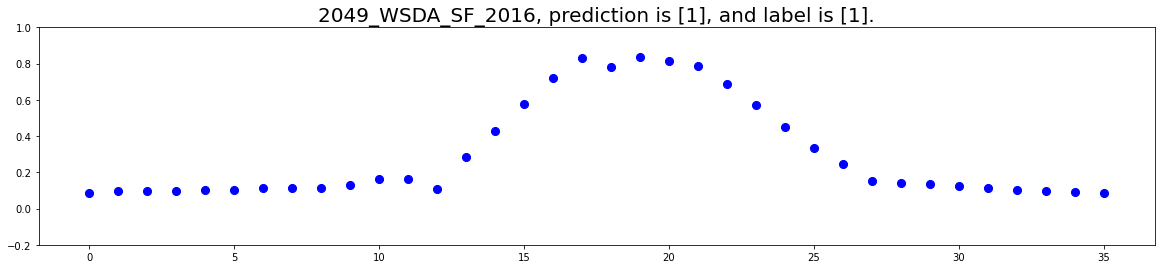

In [241]:
# Returns a NumPy Array
# Predict for One Observation (image)
test_index = 0
ID = x_test_df.iloc[test_index,].ID
prediction = logisticRegr.predict(x_test_df.iloc[test_index, 1:].values.reshape(1,-1))
print ("prediction is {}.".format(prediction))

######################################################
plt.figure(figsize=(20,4))
plt.subplot(1, 1, 1)

proper_index = x_test_df.index[test_index]
plt.scatter(range(len(x_test_df.loc[proper_index, "EVI_1":"EVI_36"])),
            x_test_df.loc[proper_index, "EVI_1":"EVI_36"].values,
            marker='o', s=65, c='b', label=VI_idx);
plt.ylim([-0.2, 1])

curr_V = str(y_test_df[y_test_df.ID == ID].Vote.values[0])
title = ID + ", prediction is " + str(prediction) + ", and label is [" + curr_V + "]."
plt.title(title , fontsize = 20);

In [242]:
# plt.scatter(range(len(x_test_df.iloc[test_index, 1:])),
#             x_test_df.iloc[test_index, 1:].values,
#             marker='o', s=65, c='b', label=VI_idx);
# plt.ylim([-0.2, 1])

In [ ]:
confusion_table = pd.DataFrame(columns=['None', 'Predict_Single', 'Predict_Double'], index=range(2))
confusion_table.loc[0, 'None'] = 'Actual_Single'
confusion_table.loc[1, 'None'] = 'Actual_Double'
confusion_table['Predict_Single']=0
confusion_table['Predict_Double']=0

actual_double_predicted_single=[]

for integer_idx in range(len(x_test_df.index)):
    ID = x_test_df.iloc[integer_idx,].ID


    prediction = logisticRegr.predict(x_test_df.iloc[integer_idx, 1:].values.reshape(1,-1))
    prediction = prediction[0]
    curr_V = y_test_df[y_test_df.ID == ID].Vote.values[0]
    
    if prediction==curr_V==1:
        confusion_table.loc[0, "Predict_Single"]+=1
    elif prediction==curr_V==2:
        confusion_table.loc[1, "Predict_Double"]+=1
    
    elif prediction!=curr_V:
        if prediction==1:
            confusion_table.loc[1, "Predict_Single"]+=1
            actual_double_predicted_single += [ID]
        elif prediction==2:
            confusion_table.loc[0, "Predict_Double"]+=1
            

confusion_table

In [244]:
confusion_table

,None,Predict_Single,Predict_Double
0,Actual_Single,307,5
1,Actual_Double,24,34


# Read Raw data so we can plot them

In [245]:
raw_dir = "/Users/hn/Documents/01_research_data/NASA/VI_TS/data_for_train_individual_counties/"

raw_names = ["L7_T1C2L2_Scaled_AdamBenton2016_2015-01-01_2017-10-14.csv", 
             "L7_T1C2L2_Scaled_FranklinYakima2018_2017-01-01_2019-10-14.csv", 
             "L7_T1C2L2_Scaled_Grant2017_2016-01-01_2018-10-14.csv", 
             "L7_T1C2L2_Scaled_Walla2015_2014-01-01_2016-12-31.csv",
             "L8_T1C2L2_Scaled_AdamBenton2016_2015-01-01_2017-10-14.csv",
             "L8_T1C2L2_Scaled_FranklinYakima2018_2017-01-01_2019-10-14.csv",
             "L8_T1C2L2_Scaled_Grant2017_2016-01-01_2018-10-14.csv",
             "L8_T1C2L2_Scaled_Walla2015_2014-01-01_2016-12-31.csv"]

raw_data=pd.DataFrame()

for file in raw_names:
    curr_file=pd.read_csv(raw_dir + file)
    curr_file=curr_file[["ID", VI_idx, "system_start_time"]]
    curr_file = curr_file[curr_file[VI_idx].notna()]
    curr_file=nc.add_human_start_time_by_system_start_time(curr_file)
    curr_file=curr_file[["ID", VI_idx, "human_system_start_time"]]
    # curr_file['human_system_start_time'] = pd.to_datetime(curr_file['human_system_start_time'])
    
    # These data are for 3 years. The middle one is the correct one
    all_years = sorted(curr_file.human_system_start_time.dt.year.unique())
    if len(all_years)==3 or len(all_years)==2:
        proper_year = all_years[1]
    elif len(all_years)==1:
        proper_year = all_years[0]

    curr_file = curr_file[curr_file.human_system_start_time.dt.year==proper_year]
    raw_data=pd.concat([raw_data, curr_file])

raw_data.reset_index(drop=True, inplace=True)
raw_data.head(2)



,ID,EVI,human_system_start_time
0,60413_WSDA_SF_2016,0.000437,2016-01-02
1,9968_WSDA_SF_2016,-0.010192,2016-01-02


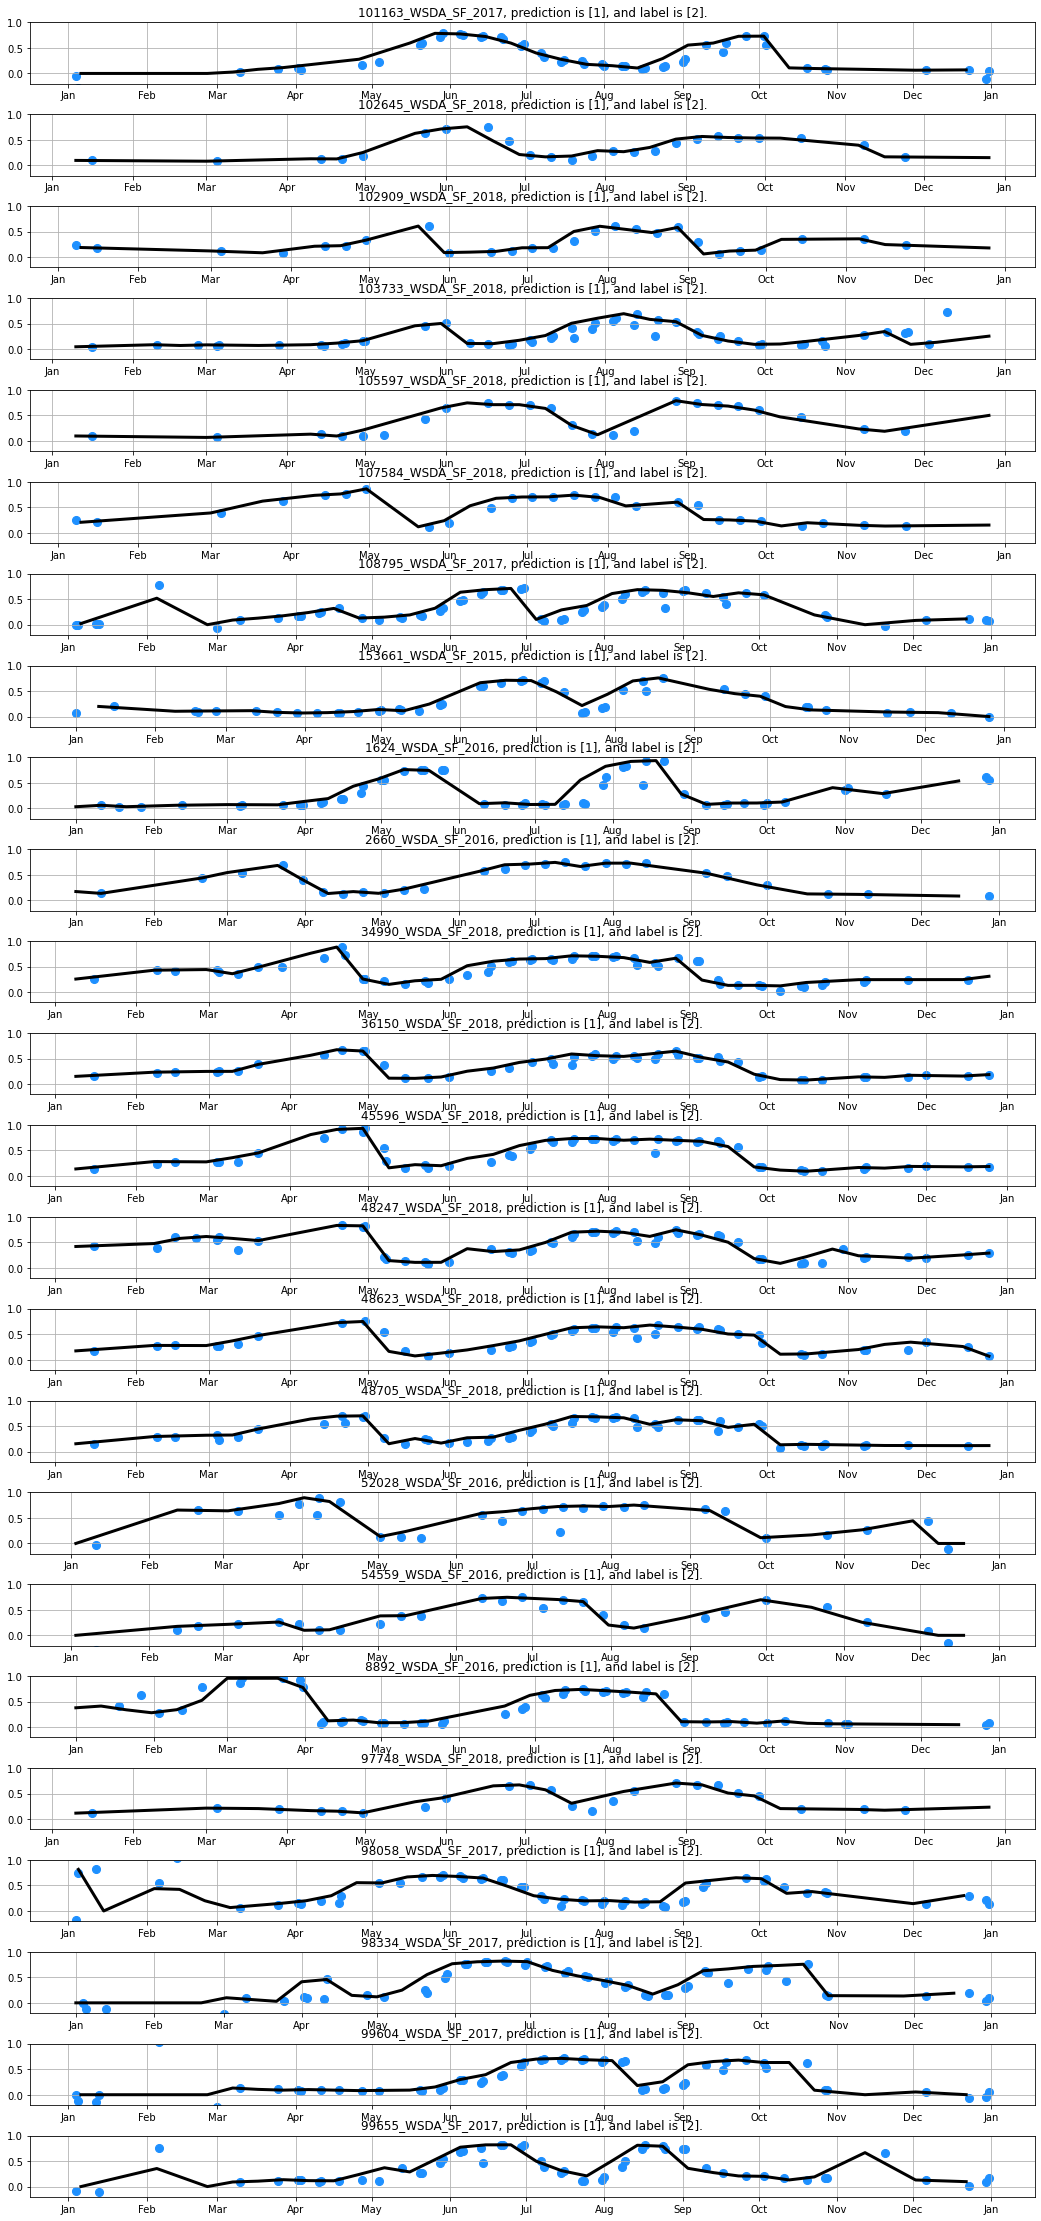

In [257]:
multiple_test_size = len(actual_double_predicted_single)
n_cols = 1
n_rows = multiple_test_size

fig, axes = plt.subplots(n_rows, 1, figsize=(18, 40), sharey='row',
                        gridspec_kw={'hspace': 0.5, 'wspace': .5});

actual_double_predicted_single = sorted(actual_double_predicted_single)
for index in range(len(actual_double_predicted_single)):
    ID = actual_double_predicted_single[index]
    prediction = logisticRegr.predict(x_test_df[x_test_df.ID == ID].values[0][1:].reshape(1,-1))
    
    xx = ground_truth[ground_truth.ID==ID]["human_system_start_time"].values[:36]
    yy = ground_truth[ground_truth.ID==ID]["EVI"].values[:36]
    axes[index].plot(xx, yy, c='k', linewidth=3);
    
    raw_xx = raw_data[raw_data.ID==ID]["human_system_start_time"]
    raw_yy = raw_data[raw_data.ID==ID]["EVI"]
    axes[index].scatter(raw_xx, raw_yy, marker='o', s=65, c='dodgerblue', label=VI_idx);

    axes[index].set_ylim([-0.2, 1])
    axes[index].grid(True); 
    
    curr_V = str(y_test_df[y_test_df.ID == ID].Vote.values[0])
    title = ID + ", prediction is " + str(prediction) + ", and label is [" + curr_V + "]."
    # axes[index].legend(loc="best")
    axes[index].set_title(title);
    axes[index].xaxis.set_major_locator(mdates.MonthLocator())
    axes[index].xaxis.set_major_formatter(DateFormatter('%b'))

# plt.tight_layout()

plot_path = "/Users/hn/Desktop/"
os.makedirs(plot_path, exist_ok=True)
fig_name = plot_path + "test_set_ActualDouble_PredictedOne_Morebands.png"
plt.savefig(fname = fig_name, dpi=100, bbox_inches='tight', facecolor="w")

### IDs of the field from preSG notebook

In [264]:
actual_double_predicted_single_preSG = ['101174_WSDA_SF_2018', '101813_WSDA_SF_2018', '102519_WSDA_SF_2017',
                                        '102715_WSDA_SF_2018', '103733_WSDA_SF_2018', '103747_WSDA_SF_2016',
                                        '104105_WSDA_SF_2016', '104106_WSDA_SF_2016', '108204_WSDA_SF_2018',
                                        '110385_WSDA_SF_2018', '36150_WSDA_SF_2018', '42916_WSDA_SF_2018',
                                        '46371_WSDA_SF_2018', '52510_WSDA_SF_2016', '56661_WSDA_SF_2016',
                                        '6394_WSDA_SF_2016', '8892_WSDA_SF_2016', '97748_WSDA_SF_2018',
                                        '98716_WSDA_SF_2017', '99064_WSDA_SF_2017', '99141_WSDA_SF_2017']

In [267]:
[x for x in actual_double_predicted_single if x in actual_double_predicted_single_preSG]

['103733_WSDA_SF_2018',
 '36150_WSDA_SF_2018',
 '8892_WSDA_SF_2016',
 '97748_WSDA_SF_2018']

# Confusion table for training set

In [ ]:
confus_tbl_train = pd.DataFrame(columns=['None', 'Predict_Single', 'Predict_Double'], index=range(2))
confus_tbl_train.loc[0, 'None'] = 'Actual_Single'
confus_tbl_train.loc[1, 'None'] = 'Actual_Double'
confus_tbl_train['Predict_Single']=0
confus_tbl_train['Predict_Double']=0

actual_double_predicted_single=[]

for idx in x_train_df.index:
    ID = x_train_df.loc[idx,].ID
    prediction = logisticRegr.predict(x_train_df.loc[idx, "EVI_1":].values.reshape(1,-1))
    prediction = prediction[0]
    curr_V = y_train_df[y_train_df.ID == ID].Vote.values[0]
    
    if prediction==curr_V==1:
        confus_tbl_train.loc[0, "Predict_Single"]+=1
    elif prediction==curr_V==2:
        confus_tbl_train.loc[1, "Predict_Double"]+=1
    
    elif prediction!=curr_V:
        if prediction==1:
            confus_tbl_train.loc[1, "Predict_Single"]+=1
            actual_double_predicted_single += [ID]
        elif prediction==2:
            confus_tbl_train.loc[0, "Predict_Double"]+=1
            
confus_tbl_train

# Horrible? on train set.
We are underfitting?
   - Logistic Regression with Ratios.
   - Plot learning curves
   - Use a larger train set and cross validation!
   - Diagnose (how?)
   - Tune parameters (what parameters?)
   - Look at AIC, BIC? Good reminder.
   - Exponential (or other types of) smoothing?
   - Forget about logistic: try
       - Distance-based (KNN with dynamic time warping)
       - Interval-based (TimeSeriesForest)
       - Dictionary-based (BOSS, cBOSS)
       - Frequency-based (RISE — like TimeSeriesForest but with other features)
       - Shapelet-based (Shapelet Transform Classifier)

In [ ]:
# Make an instance of the Model
# all parameters not specified are set to their defaults

# random_state is used for solver == ‘sag’, ‘saga’ or ‘liblinear’
logisticRegr = LogisticRegression(random_state=0,
                                  class_weight="balanced");
logisticRegr.fit(x_train_df.loc[:, "EVI_1":"EVI_36"], y_train_df.Vote.values);

In [ ]:
confus_tbl_train = pd.DataFrame(columns=['None', 'Predict_Single', 'Predict_Double'], index=range(2))
confus_tbl_train.loc[0, 'None'] = 'Actual_Single'
confus_tbl_train.loc[1, 'None'] = 'Actual_Double'
confus_tbl_train['Predict_Single']=0
confus_tbl_train['Predict_Double']=0

actual_double_predicted_single=[]

for idx in x_train_df.index:
    ID = x_train_df.loc[idx,].ID
    prediction = logisticRegr.predict(x_train_df.loc[idx, "EVI_1":].values.reshape(1,-1))
    prediction = prediction[0]
    curr_V = y_train_df[y_train_df.ID == ID].Vote.values[0]
    
    if prediction==curr_V==1:
        confus_tbl_train.loc[0, "Predict_Single"]+=1
    elif prediction==curr_V==2:
        confus_tbl_train.loc[1, "Predict_Double"]+=1
    
    elif prediction!=curr_V:
        if prediction==1:
            confus_tbl_train.loc[1, "Predict_Single"]+=1
            actual_double_predicted_single += [ID]
        elif prediction==2:
            confus_tbl_train.loc[0, "Predict_Double"]+=1
            
confus_tbl_train

In [ ]:
print((ground_truth_labels.Vote==1).sum()/(ground_truth_labels.Vote==2).sum())

In [ ]:
# Make an instance of the Model
# all parameters not specified are set to their defaults
from sklearn.linear_model import LogisticRegressionCV
logisticRegr_CV = LogisticRegressionCV(max_iter=100000, cv=10)
logisticRegr_CV.fit(ground_truth_wide.loc[:, "EVI_1":], ground_truth_labels.Vote.values)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = load_digits(return_X_y=True)

title = "Learning Curves (Naive Bayes)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, 
                    X=ground_truth_wide.loc[:, "EVI_1":], 
                    y=ground_truth_labels.Vote.values, 
                    axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

In [ ]:
f_name = "/Users/hn/Documents/01_research_data/NASA/" +\
         "VI_TS/moreBands_train_set/" +\
         "L8_T1C2L2_Scaled_FranklinYakima2018_2018-01-01_2019-01-01.csv"
A = pd.read_csv(f_name)

In [ ]:
A.head(2)

In [ ]:
L = len(A['SR_B2'].index[A['SR_B2'].apply(np.isnan)])

In [ ]:
cc="SR_B3"
sum(A['SR_B2'].index[A['SR_B2'].apply(np.isnan)] == A[cc].index[A[cc].apply(np.isnan)])

In [ ]:
len(A['SR_B2'].index[A['SR_B2'].apply(np.isnan)])

In [ ]:
len(A[cc].index[A[cc].apply(np.isnan)])

In [ ]:
V = A['SR_B2'].index[A['SR_B2'].apply(np.isnan)].isin(A[cc].index[A[cc].apply(np.isnan)])

In [ ]:
V = list(V)

In [ ]:
V.index(False)

In [ ]:
A['SR_B2'].index[A['SR_B2'].apply(np.isnan)][334116]

In [ ]:
A.head(2)

In [ ]:
L8_dict = {"SR_B2":"blue",
           "SR_B3":"green",
           "SR_B4":"red",
           "SR_B5":"NIR",
           "SR_B6":"short_I_1",
           "SR_B7":"short_I_2",
           }

In [ ]:
A.head(2)